In [1]:
import nfl_data_py as nfl
import pandas as pd

years = list(range(2000, 2024))

schedules = nfl.import_schedules(years)
print(schedules.shape)
print(schedules.head())
schedules.to_csv("nfl_schedules.csv", index=False)

(6447, 46)
             game_id  season game_type  week     gameday weekday gametime  \
259   2000_01_SF_ATL    2000       REG     1  2000-09-03  Sunday    13:00   
260  2000_01_JAX_CLE    2000       REG     1  2000-09-03  Sunday    13:00   
261   2000_01_IND_KC    2000       REG     1  2000-09-03  Sunday    13:00   
262  2000_01_CHI_MIN    2000       REG     1  2000-09-03  Sunday    13:00   
263    2000_01_TB_NE    2000       REG     1  2000-09-03  Sunday    13:00   

    away_team  away_score home_team  ...  wind  away_qb_id  home_qb_id  \
259        SF          28       ATL  ...   NaN  00-0005755  00-0002876   
260       JAX          27       CLE  ...   6.0  00-0002110  00-0003535   
261       IND          27        KC  ...   5.0  00-0010346  00-0006300   
262       CHI          27       MIN  ...   NaN  00-0011044  00-0003739   
263        TB          21        NE  ...   5.0  00-0009266  00-0001361   

       away_qb_name      home_qb_name      away_coach          home_coach  \
259 

In [2]:
def calculate_team_wins(schedules):
    records = []
    
    # Filter to regular season only
    reg = schedules[schedules["game_type"] == "REG"].copy()
    
    # Drop games that haven't been played yet (no score)
    reg = reg.dropna(subset=["home_score", "away_score"])
    
    for _, row in reg.iterrows():
        home_win = 1 if row["home_score"] > row["away_score"] else 0
        away_win = 1 if row["away_score"] > row["home_score"] else 0
        
        records.append({
            "season": row["season"],
            "team": row["home_team"],
            "win": home_win
        })
        records.append({
            "season": row["season"],
            "team": row["away_team"],
            "win": away_win
        })
    
    df = pd.DataFrame(records)
    team_wins = df.groupby(["season", "team"])["win"].sum().reset_index()
    team_wins.columns = ["season", "team", "wins"]
    
    return team_wins

team_wins = calculate_team_wins(schedules)
print(team_wins.head(20))
print(f"\nShape: {team_wins.shape}")
team_wins.to_csv("nfl_team_wins.csv", index=False)

    season team  wins
0     2000  ARI     3
1     2000  ATL     4
2     2000  BAL    12
3     2000  BUF     8
4     2000  CAR     7
5     2000  CHI     5
6     2000  CIN     4
7     2000  CLE     3
8     2000  DAL     5
9     2000  DEN    11
10    2000  DET     9
11    2000   GB     9
12    2000  IND    10
13    2000  JAX     7
14    2000   KC     7
15    2000  MIA    11
16    2000  MIN    11
17    2000   NE     5
18    2000   NO    10
19    2000  NYG    12

Shape: (766, 3)


In [4]:
# Pull team level stats
team_stats = nfl.import_team_desc()
print(team_stats.columns.tolist())

# The main team stats come from the schedules we already have
# Let's engineer team level features from the schedules data
reg_season = schedules[schedules["game_type"] == "REG"].dropna(subset=["home_score", "away_score"])

# Build team stats per season from schedules
home_stats = reg_season[["season", "home_team", "home_score", "away_score"]].copy()
home_stats.columns = ["season", "team", "points_for", "points_against"]

away_stats = reg_season[["season", "away_team", "away_score", "home_score"]].copy()
away_stats.columns = ["season", "team", "points_for", "points_against"]

all_games = pd.concat([home_stats, away_stats], ignore_index=True)

team_season_stats = all_games.groupby(["season", "team"]).agg(
    points_for=("points_for", "sum"),
    points_against=("points_against", "sum"),
    games_played=("points_for", "count")
).reset_index()

# Add points per game features
team_season_stats["ppg_for"] = team_season_stats["points_for"] / team_season_stats["games_played"]
team_season_stats["ppg_against"] = team_season_stats["points_against"] / team_season_stats["games_played"]
team_season_stats["point_diff"] = team_season_stats["points_for"] - team_season_stats["points_against"]

# Merge with win totals
model_data = team_season_stats.merge(team_wins, on=["season", "team"])

print(model_data.head())
print(f"\nShape: {model_data.shape}")
model_data.to_csv("nfl_model_data.csv", index=False)

['team_abbr', 'team_name', 'team_id', 'team_nick', 'team_conf', 'team_division', 'team_color', 'team_color2', 'team_color3', 'team_color4', 'team_logo_wikipedia', 'team_logo_espn', 'team_wordmark', 'team_conference_logo', 'team_league_logo', 'team_logo_squared']
   season team  points_for  points_against  games_played  ppg_for  \
0    2000  ARI         210             443            16  13.1250   
1    2000  ATL         252             413            16  15.7500   
2    2000  BAL         333             165            16  20.8125   
3    2000  BUF         315             350            16  19.6875   
4    2000  CAR         310             310            16  19.3750   

   ppg_against  point_diff  wins  
0      27.6875        -233     3  
1      25.8125        -161     4  
2      10.3125         168    12  
3      21.8750         -35     8  
4      19.3750           0     7  

Shape: (766, 9)


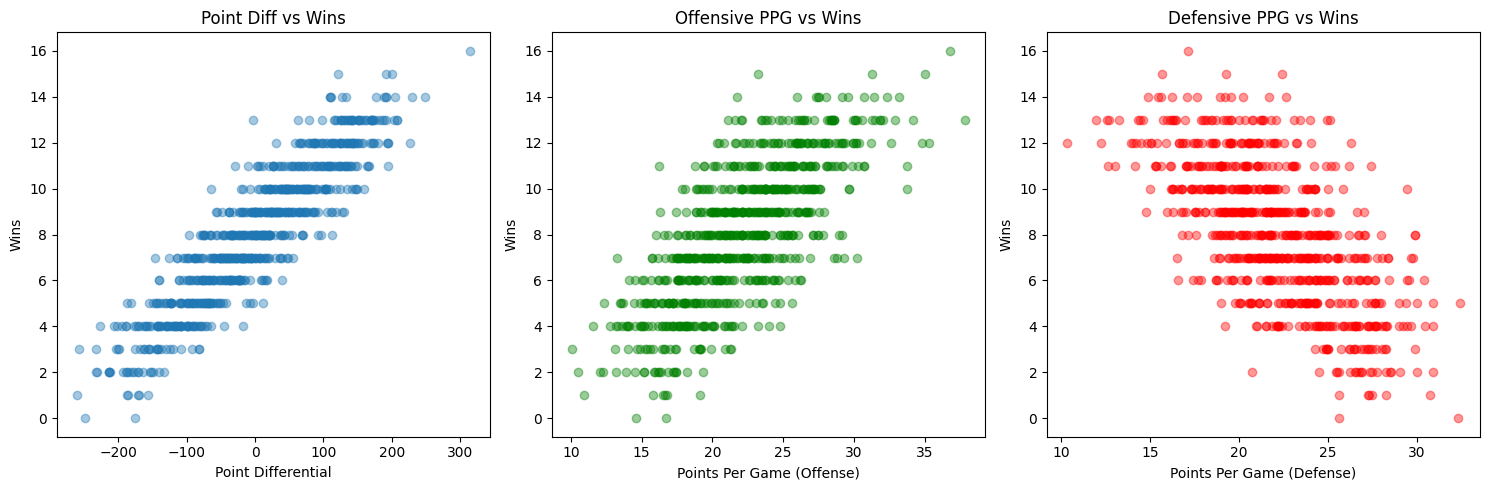

Training samples: 670, Test samples: 96
Linear Regression    → MAE: 1.16 wins  |  RMSE: 1.47 wins
Random Forest        → MAE: 1.10 wins  |  RMSE: 1.43 wins
XGBoost              → MAE: 1.32 wins  |  RMSE: 1.67 wins


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ── EDA ──────────────────────────────────────────────────────────────────────

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(model_data["point_diff"], model_data["wins"], alpha=0.4)
axes[0].set_xlabel("Point Differential")
axes[0].set_ylabel("Wins")
axes[0].set_title("Point Diff vs Wins")

axes[1].scatter(model_data["ppg_for"], model_data["wins"], alpha=0.4, color="green")
axes[1].set_xlabel("Points Per Game (Offense)")
axes[1].set_ylabel("Wins")
axes[1].set_title("Offensive PPG vs Wins")

axes[2].scatter(model_data["ppg_against"], model_data["wins"], alpha=0.4, color="red")
axes[2].set_xlabel("Points Per Game (Defense)")
axes[2].set_ylabel("Wins")
axes[2].set_title("Defensive PPG vs Wins")

plt.tight_layout()
plt.savefig("eda_plots.png")
plt.show()

# ── MODEL ─────────────────────────────────────────────────────────────────────

features = ["points_for", "points_against", "ppg_for", "ppg_against", "point_diff"]
target = "wins"

X = model_data[features]
y = model_data[target]

# Temporal split — train on 2000-2020, test on 2021-2023
train = model_data[model_data["season"] <= 2020]
test  = model_data[model_data["season"] >  2020]

X_train, y_train = train[features], train[target]
X_test,  y_test  = test[features],  test[target]

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

# Train three models and compare
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest":     RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost":           XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae  = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"{name:20s} → MAE: {mae:.2f} wins  |  RMSE: {rmse:.2f} wins")